## Automatically find cuts using CKT

#### Create a circuit and observables

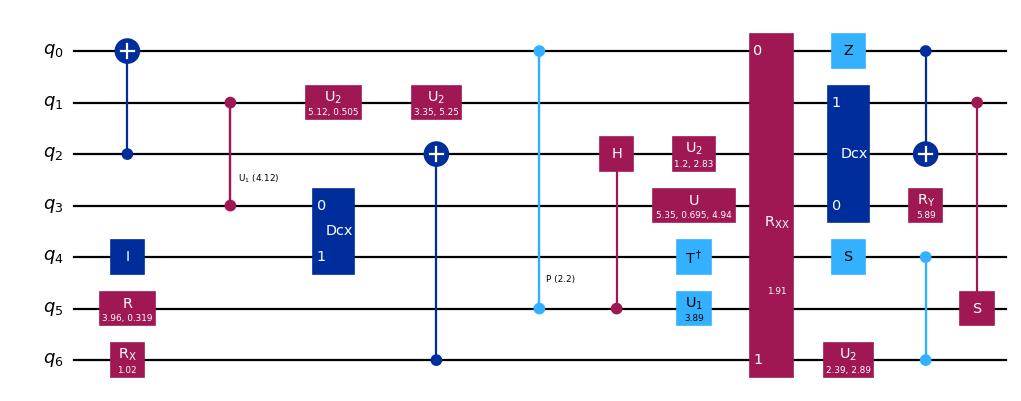

In [1]:
import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import PauliList

circuit = random_circuit(7, 5, max_operands=2)
observables = PauliList(["ZIIIIII", "IIIZIII", "IIIIIIZ"])
circuit.draw("mpl", scale=0.8, style="iqp", fold=-1)

#### Find cut locations, given two QPUs with 4 qubits each

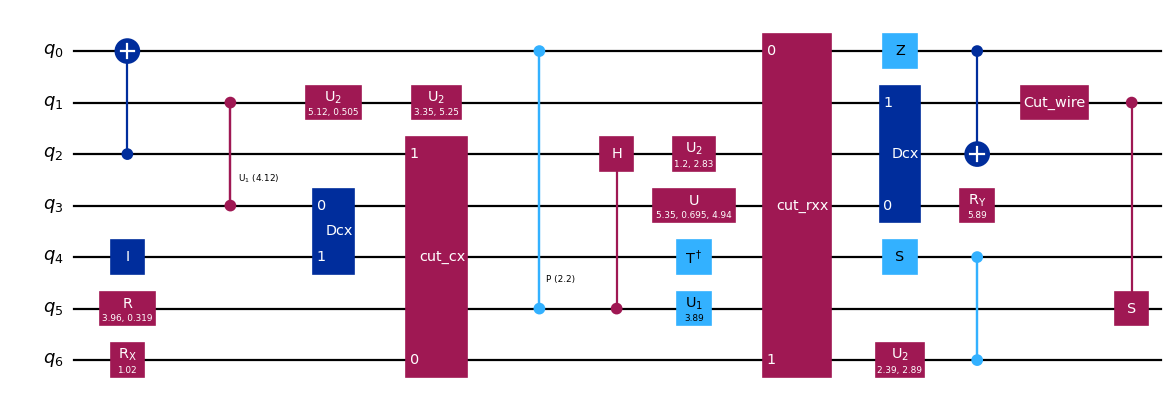

In [2]:
from circuit_knitting.cutting import find_cuts

# Specify settings for the cut-finding optimizer
optimization_settings = {"rand_seed": 111}

# Specify the size and number of the QPUs available
device_constraints = {"qubits_per_QPU": 4, "num_QPUs": 2}

cut_circuit = find_cuts(circuit, optimization_settings, device_constraints)
cut_circuit.draw("mpl", style="iqp", scale=0.8, fold=-1)

#### Add ancillas for wire cuts and expand the observables to account for ancilla qubits

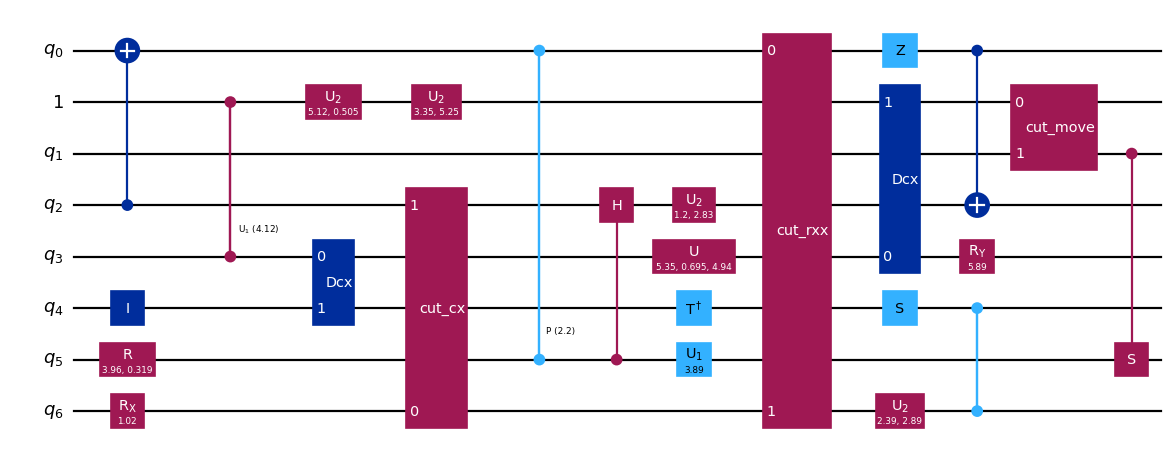

In [3]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", style="iqp", scale=0.8, fold=-1)

#### Partition the circuit and observables into subcircuits and subobservables. Calculate the sampling overhead incurred from cutting these gates and wires.

In [4]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(circuit=qc_w_ancilla, observables=observables_expanded)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}")

Sampling overhead: 1201.0166532117305


In [5]:
subobservables

{0: PauliList(['IIII', 'IIII', 'IIIZ']),
 1: PauliList(['ZIII', 'IIZI', 'IIII'])}

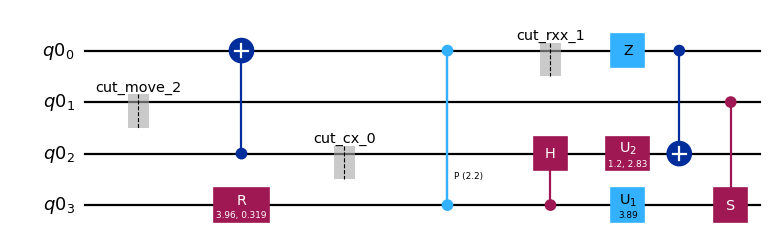

In [6]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

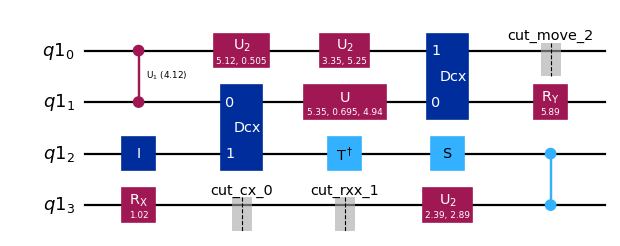

In [7]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

#### Generate the experiments to run on the backend.

In [10]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(circuits=subcircuits, observables=subobservables, num_samples=np.inf)
print(f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend.")

576 total subexperiments to run on backend.
